# Satvision-TOA Reconstruction Notebook

Version: 04.30.24

Env: `Python [conda env:ilab-pytorch]`

In [1]:
!pip install yacs timm segmentation-models-pytorch termcolor webdataset==0.2.86

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import sys
import time
import random
import datetime
from tqdm import tqdm
import numpy as np
import logging

import torch
import torch.cuda.amp as amp

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import warnings

warnings.filterwarnings('ignore') 

In [3]:
sys.path.append('../../pytorch-caney')

from pytorch_caney.config import get_config

from pytorch_caney.models.build import build_model

from pytorch_caney.ptc_logging import create_logger

from pytorch_caney.data.datasets.mim_modis_22m_dataset import MODIS22MDataset

from pytorch_caney.data.transforms import SimmimTransform, SimmimMaskGenerator

from pytorch_caney.config import _C, _update_config_from_file

## 1. Configuration

### Clone model ckpt from huggingface

### Model repo: https://huggingface.co/nasa-cisto-data-science-group/satvision-toa-huge-patch8-window8-128

```bash
# On prism/explore
module load git-lfs

git lfs install

git clone git clone git@hf.co:nasa-cisto-data-science-group/satvision-toa-huge-patch8-window8-128
```

Note: If using git w/ ssh, make sure you have ssh keys enabled to clone using ssh auth.
https://huggingface.co/docs/hub/security-git-ssh

```bash
eval $(ssh-agent)

# If this outputs as anon, follow the next steps.
ssh -T git@hf.co

# Check if ssh-agent is using the proper key
ssh-add -l

# If not
ssh-add ~/.ssh/your-key

# Or if you want to use the default id_* key, just do
ssh-add

```

In [4]:
MODEL_PATH: str = '/explore/nobackup/people/cssprad1/projects/satvision-toa/models/satvision-toa-giant-patch8-window8-128/mp_rank_00_model_states.pt'
CONFIG_PATH: str = '/explore/nobackup/people/cssprad1/projects/satvision-toa/models/satvision-toa-giant-patch8-window8-128/mim_pretrain_swinv2_satvision_giant_128_window08_50ep.yaml'

OUTPUT: str = '.'
TAG: str = 'satvision-huge-toa-reconstruction'
DATA_PATH: str = '/explore/nobackup/projects/ilab/projects/3DClouds/data/validation/sv_toa_128_chip_validation_04_24.npy'
DATA_PATHS: list = [DATA_PATH]

In [5]:
# Update config given configurations

config = _C.clone()
_update_config_from_file(config, CONFIG_PATH)

config.defrost()
config.MODEL.RESUME = MODEL_PATH
config.DATA.DATA_PATHS = DATA_PATHS
config.OUTPUT = OUTPUT
config.TAG = TAG
config.freeze()

=> merge config from /explore/nobackup/people/cssprad1/projects/satvision-toa/models/satvision-toa-giant-patch8-window8-128/mim_pretrain_swinv2_satvision_giant_128_window08_50ep.yaml


In [6]:
# Configure logging
logging.basicConfig(
    filename='app.log',  # Specify the log file name
    level=logging.INFO,  # Set logging level to DEBUG
    format='%(asctime)s [%(levelname)s] %(message)s',  # Specify log message format
    datefmt='%Y-%m-%d %H:%M:%S'  # Specify date format
)

# Add logging to standard output
console = logging.StreamHandler()  # Create a handler for standard output
console.setLevel(logging.INFO)  # Set logging level for standard output
console.setFormatter(logging.Formatter('%(asctime)s [%(levelname)s] %(message)s'))  # Set log message format for standard output
logger = logging.getLogger('')
logger.addHandler(console)

## 2. Load model weights from checkpoint

In [7]:
checkpoint = torch.load(MODEL_PATH)
model = build_model(config, pretrain=True)
model.load_state_dict(checkpoint['module']) # If 'module' not working, try 'model'
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info(f"number of params: {n_parameters}")
# model.cuda()
model.eval()

2024-09-20 14:37:24,629 [INFO] number of params: 2653783008


MiMModel(
  (encoder): SwinTransformerV2ForSimMIM(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(14, 512, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=512, input_resolution=(32, 32), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=512, input_resolution=(32, 32),num_heads=16, window_size=8, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=512, window_size=(8, 8), pretrained_window_size=(0, 0), num_heads=16
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=16, bias=False)
              )
              (qkv): Li

## 3. Load evaluation set (from numpy file)

In [8]:
import torchvision.transforms as T
from pytorch_caney.data.utils import RandomResizedCropNP, SimmimMaskGenerator

class MinMaxEmissiveScaleReflectance(object):
    """
    Performs scaling of MODIS TOA data
    - Scales reflectance percentages to reflectance units (% -> (0,1))
    - Performs per-channel minmax scaling for emissive bands (k -> (0,1))
    """

    def __init__(self):
        
        self.reflectance_indices = [0, 1, 2, 3, 4, 6]
        self.emissive_indices = [5, 7, 8, 9, 10, 11, 12, 13]

        self.emissive_mins = np.array(
            [223.1222, 178.9174, 204.3739, 204.7677,
             194.8686, 202.1759, 201.3823, 203.3537],
            dtype=np.float32)

        self.emissive_maxs = np.array(
            [352.7182, 261.2920, 282.5529, 319.0373,
             295.0209, 324.0677, 321.5254, 285.9848],
            dtype=np.float32)

    def __call__(self, img):
        
        # Reflectance % to reflectance units
        img[:, :, self.reflectance_indices] = \
            img[:, :, self.reflectance_indices] * 0.01
        
        # Brightness temp scaled to (0,1) range
        img[:, :, self.emissive_indices] = \
            (img[:, :, self.emissive_indices] - self.emissive_mins) / \
                (self.emissive_maxs - self.emissive_mins)
        
        return img


class SimmimTransform:
    """
    torchvision transform which transforms the input imagery into
    addition to generating a MiM mask
    """

    def __init__(self, config):

        self.transform_img = \
            T.Compose([
                MinMaxEmissiveScaleReflectance(), # New transform for MinMax
                T.ToTensor(),
                T.Resize((config.DATA.IMG_SIZE, config.DATA.IMG_SIZE)),
            ])

        if config.MODEL.TYPE in ['swin', 'swinv2']:

            model_patch_size = config.MODEL.SWINV2.PATCH_SIZE

        else:

            raise NotImplementedError

        self.mask_generator = SimmimMaskGenerator(
            input_size=config.DATA.IMG_SIZE,
            mask_patch_size=config.DATA.MASK_PATCH_SIZE,
            model_patch_size=model_patch_size,
            mask_ratio=config.DATA.MASK_RATIO,
        )

    def __call__(self, img):

        img = self.transform_img(img)
        mask = self.mask_generator()

        return img, mask

In [9]:
# Use the Masked-Image-Modeling transform
transform = SimmimTransform(config)

# The reconstruction evaluation set is a single numpy file
validation_dataset_path = config.DATA.DATA_PATHS[0]
validation_dataset = np.load(validation_dataset_path)
len_batch = range(validation_dataset.shape[0])

# Apply transform to each image in the batch
# A mask is auto-generated in the transform
imgMasks = [transform(validation_dataset[idx]) for idx \
    in len_batch]

# Seperate img and masks, cast masks to torch tensor
img = torch.stack([imgMask[0] for imgMask in imgMasks])
mask = torch.stack([torch.from_numpy(imgMask[1]) for \
    imgMask in imgMasks])

In [10]:
idx_to_band = {
    0: 1,
    1: 2,
    2: 3,
    3: 6,
    4: 7,
    5: 21,
    6: 26,
    7: 27,
    8: 28,
    9: 29,
    10: 30,
    11: 31,
    12: 32,
    13: 33
}


def get_batch_info(img):
    
    channels = img.shape[1]
    
    for channelIdx in range(channels):
        channel = idx_to_band[channelIdx]
        img_band_array = img[:, channelIdx, :, :]
        min_ = img_band_array.min()
        mean_ = img_band_array.mean()
        max_ = img_band_array.max()
        print(f'Channel {channel}, min {min_}, mean {mean_}, max {max_}') 

In [11]:
get_batch_info(img)

Channel 1, min 0.02055743709206581, mean 0.23059538006782532, max 1.0075911283493042
Channel 2, min 0.010388242080807686, mean 0.2926776707172394, max 0.9048148393630981
Channel 3, min 0.051274485886096954, mean 0.2630060315132141, max 1.048071026802063
Channel 6, min 0.002602405147626996, mean 0.2257007360458374, max 0.6810641884803772
Channel 7, min 0.0013291973154991865, mean 0.15059055387973785, max 0.6122391223907471
Channel 21, min -1.1774119457186316e-07, mean 0.5202993154525757, max 0.9999997615814209
Channel 26, min -0.0045103696174919605, mean 0.030210332944989204, max 0.5251043438911438
Channel 27, min 1.85236601168981e-07, mean 0.7143893837928772, max 0.9999996423721313
Channel 28, min 0.0, mean 0.5836189985275269, max 1.0000008344650269
Channel 29, min 1.3353324845866155e-07, mean 0.6119444370269775, max 0.9999997615814209
Channel 30, min 0.0, mean 0.6182008385658264, max 0.9999997019767761
Channel 31, min 2.5036615625140257e-07, mean 0.6037113666534424, max 1.000000238418

## 4. Prediction helper functions

In [12]:
def predict(model, dataloader, num_batches=5):

    inputs = []
    outputs = []
    masks = []
    losses = []
    with tqdm(total=num_batches) as pbar:

        for idx, img_mask in enumerate(dataloader):
            
            pbar.update(1)

            if idx > num_batches:
                return inputs, outputs, masks, losses

            img_mask = img_mask[0]

            img = torch.stack([pair[0] for pair in img_mask])
            mask = torch.stack([pair[1] for pair in img_mask])

            img = img.cuda(non_blocking=True)
            mask = mask.cuda(non_blocking=True)

            with torch.no_grad():
                with amp.autocast(enabled=config.ENABLE_AMP):
                    z = model.encoder(img, mask)
                    img_recon = model.decoder(z)
                    loss = model(img, mask)

            inputs.extend(img.cpu())
            masks.extend(mask.cpu())
            outputs.extend(img_recon.cpu())
            losses.append(loss.cpu())
    
    return inputs, outputs, masks, losses


def minmax_norm(img_arr):
    arr_min = img_arr.min()
    arr_max = img_arr.max()
    img_arr_scaled = (img_arr - arr_min) / (arr_max - arr_min)
    img_arr_scaled = img_arr_scaled * 255
    img_arr_scaled = img_arr_scaled.astype(np.uint8)
    return img_arr_scaled


def process_mask(mask):
    mask_img = mask.unsqueeze(0)
    mask_img = mask_img.repeat_interleave(4, 1).repeat_interleave(4, 2).unsqueeze(1).contiguous()
    mask_img = mask_img[0, 0, :, :]
    mask_img = np.stack([mask_img, mask_img, mask_img], axis=-1)
    return mask_img

def reverse_transform(image):
    minMaxTransform = MinMaxEmissiveScaleReflectance()
    image = image.transpose((1,2,0))
    
    image[:, :, minMaxTransform.reflectance_indices] = image[:, :, minMaxTransform.reflectance_indices] * 100
    image[:, :, minMaxTransform.emissive_indices] = (
        image[:, :, minMaxTransform.emissive_indices] * \
        (minMaxTransform.emissive_maxs - minMaxTransform.emissive_mins)) + minMaxTransform.emissive_mins

    image = image.transpose((2,0,1))
    return image

def process_prediction(image, img_recon, mask, rgb_index):

    mask = process_mask(mask)
    
    red_idx = rgb_index[0]
    blue_idx = rgb_index[1]
    green_idx = rgb_index[2]

    image = reverse_transform(image.numpy())
    
    img_recon = reverse_transform(img_recon.numpy())

    rgb_image = np.stack((image[red_idx, :, :],
                          image[blue_idx, :, :],
                          image[green_idx, :, :]),
                         axis=-1)
    rgb_image = minmax_norm(rgb_image)

    rgb_image_recon = np.stack((img_recon[red_idx, :, :],
                                img_recon[blue_idx, :, :],
                                img_recon[green_idx, :, :]),
                                axis=-1)
    rgb_image_recon = minmax_norm(rgb_image_recon)

    rgb_masked = np.where(mask == 0, rgb_image, rgb_image_recon)
    rgb_image_masked = np.where(mask == 1, 0, rgb_image)
    rgb_recon_masked = rgb_masked
    
    return rgb_image, rgb_image_masked, rgb_recon_masked, mask


def plot_export_pdf(path, inputs, outputs, masks, rgb_index):
    pdf_plot_obj = PdfPages(path)

    for idx in range(len(inputs)):
        # prediction processing
        image = inputs[idx]
        img_recon = outputs[idx]
        mask = masks[idx]
        rgb_image, rgb_image_masked, rgb_recon_masked, mask = \
            process_prediction(image, img_recon, mask, rgb_index)

        # matplotlib code
        fig, (ax01, ax23) = plt.subplots(2, 2, figsize=(40, 30))
        ax0, ax1 = ax01
        ax2, ax3 = ax23
        ax2.imshow(rgb_image)
        ax2.set_title(f"Idx: {idx} MOD021KM v6.1 Bands: {rgb_index}")

        ax0.imshow(rgb_recon_masked)
        ax0.set_title(f"Idx: {idx} Model reconstruction")

        ax1.imshow(rgb_image_masked)
        ax1.set_title(f"Idx: {idx} MOD021KM Bands: {rgb_index}, masked")
        
        ax3.matshow(mask[:, :, 0])
        ax3.set_title(f"Idx: {idx} Reconstruction Mask")
        pdf_plot_obj.savefig()

    pdf_plot_obj.close()

## 5. Predict

In [14]:
inputs = []
outputs = []
masks = []
losses = []

# We could do this in a single batch however we
# want to report the loss per-image, in place of
# loss per-batch.
for i in tqdm(range(5)):
    single_img = img[i].unsqueeze(0)
    single_mask = mask[i].unsqueeze(0)
    # single_img = single_img.cuda(non_blocking=True)
    # single_mask = single_mask.cuda(non_blocking=True)

    with torch.no_grad():
        z = model.encoder(single_img, single_mask)
        img_recon = model.decoder(z)
        loss = model(single_img, single_mask)

    inputs.extend(single_img.cpu())
    masks.extend(single_mask.cpu())
    outputs.extend(img_recon.cpu())
    losses.append(loss.cpu()) 

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


## 6. Plot and write to PDF

Writes out all of the predictions to a PDF file

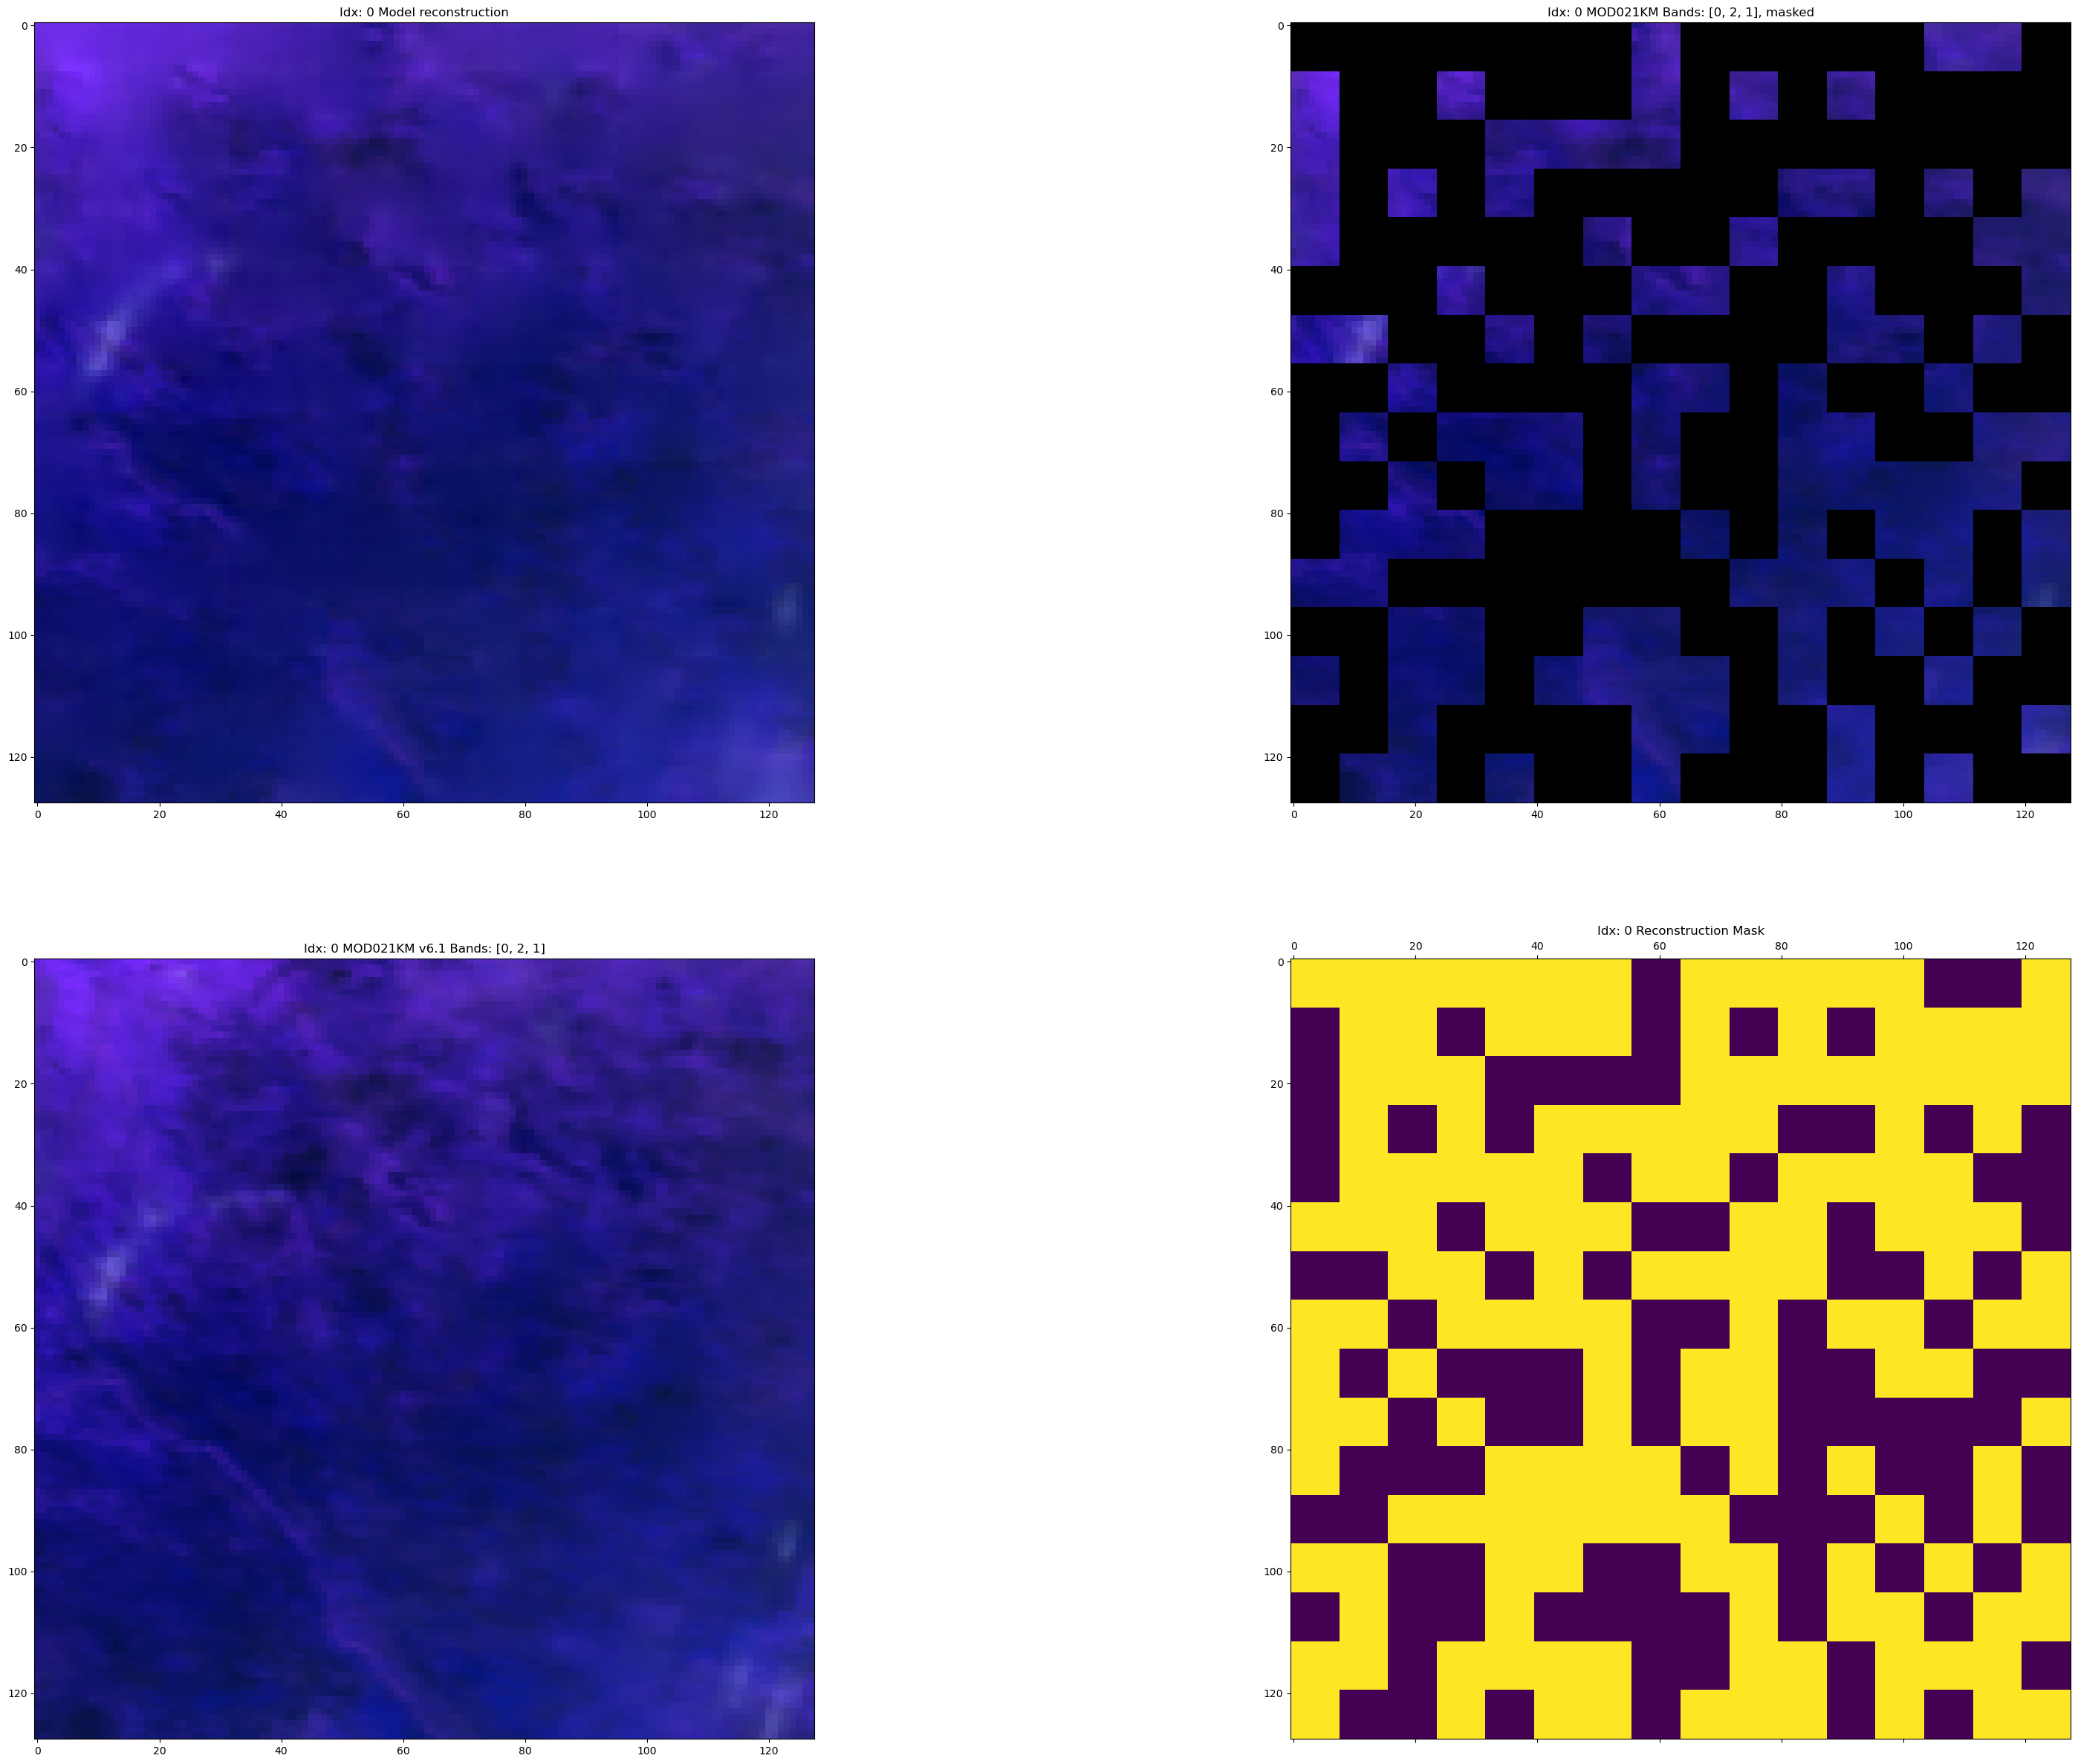

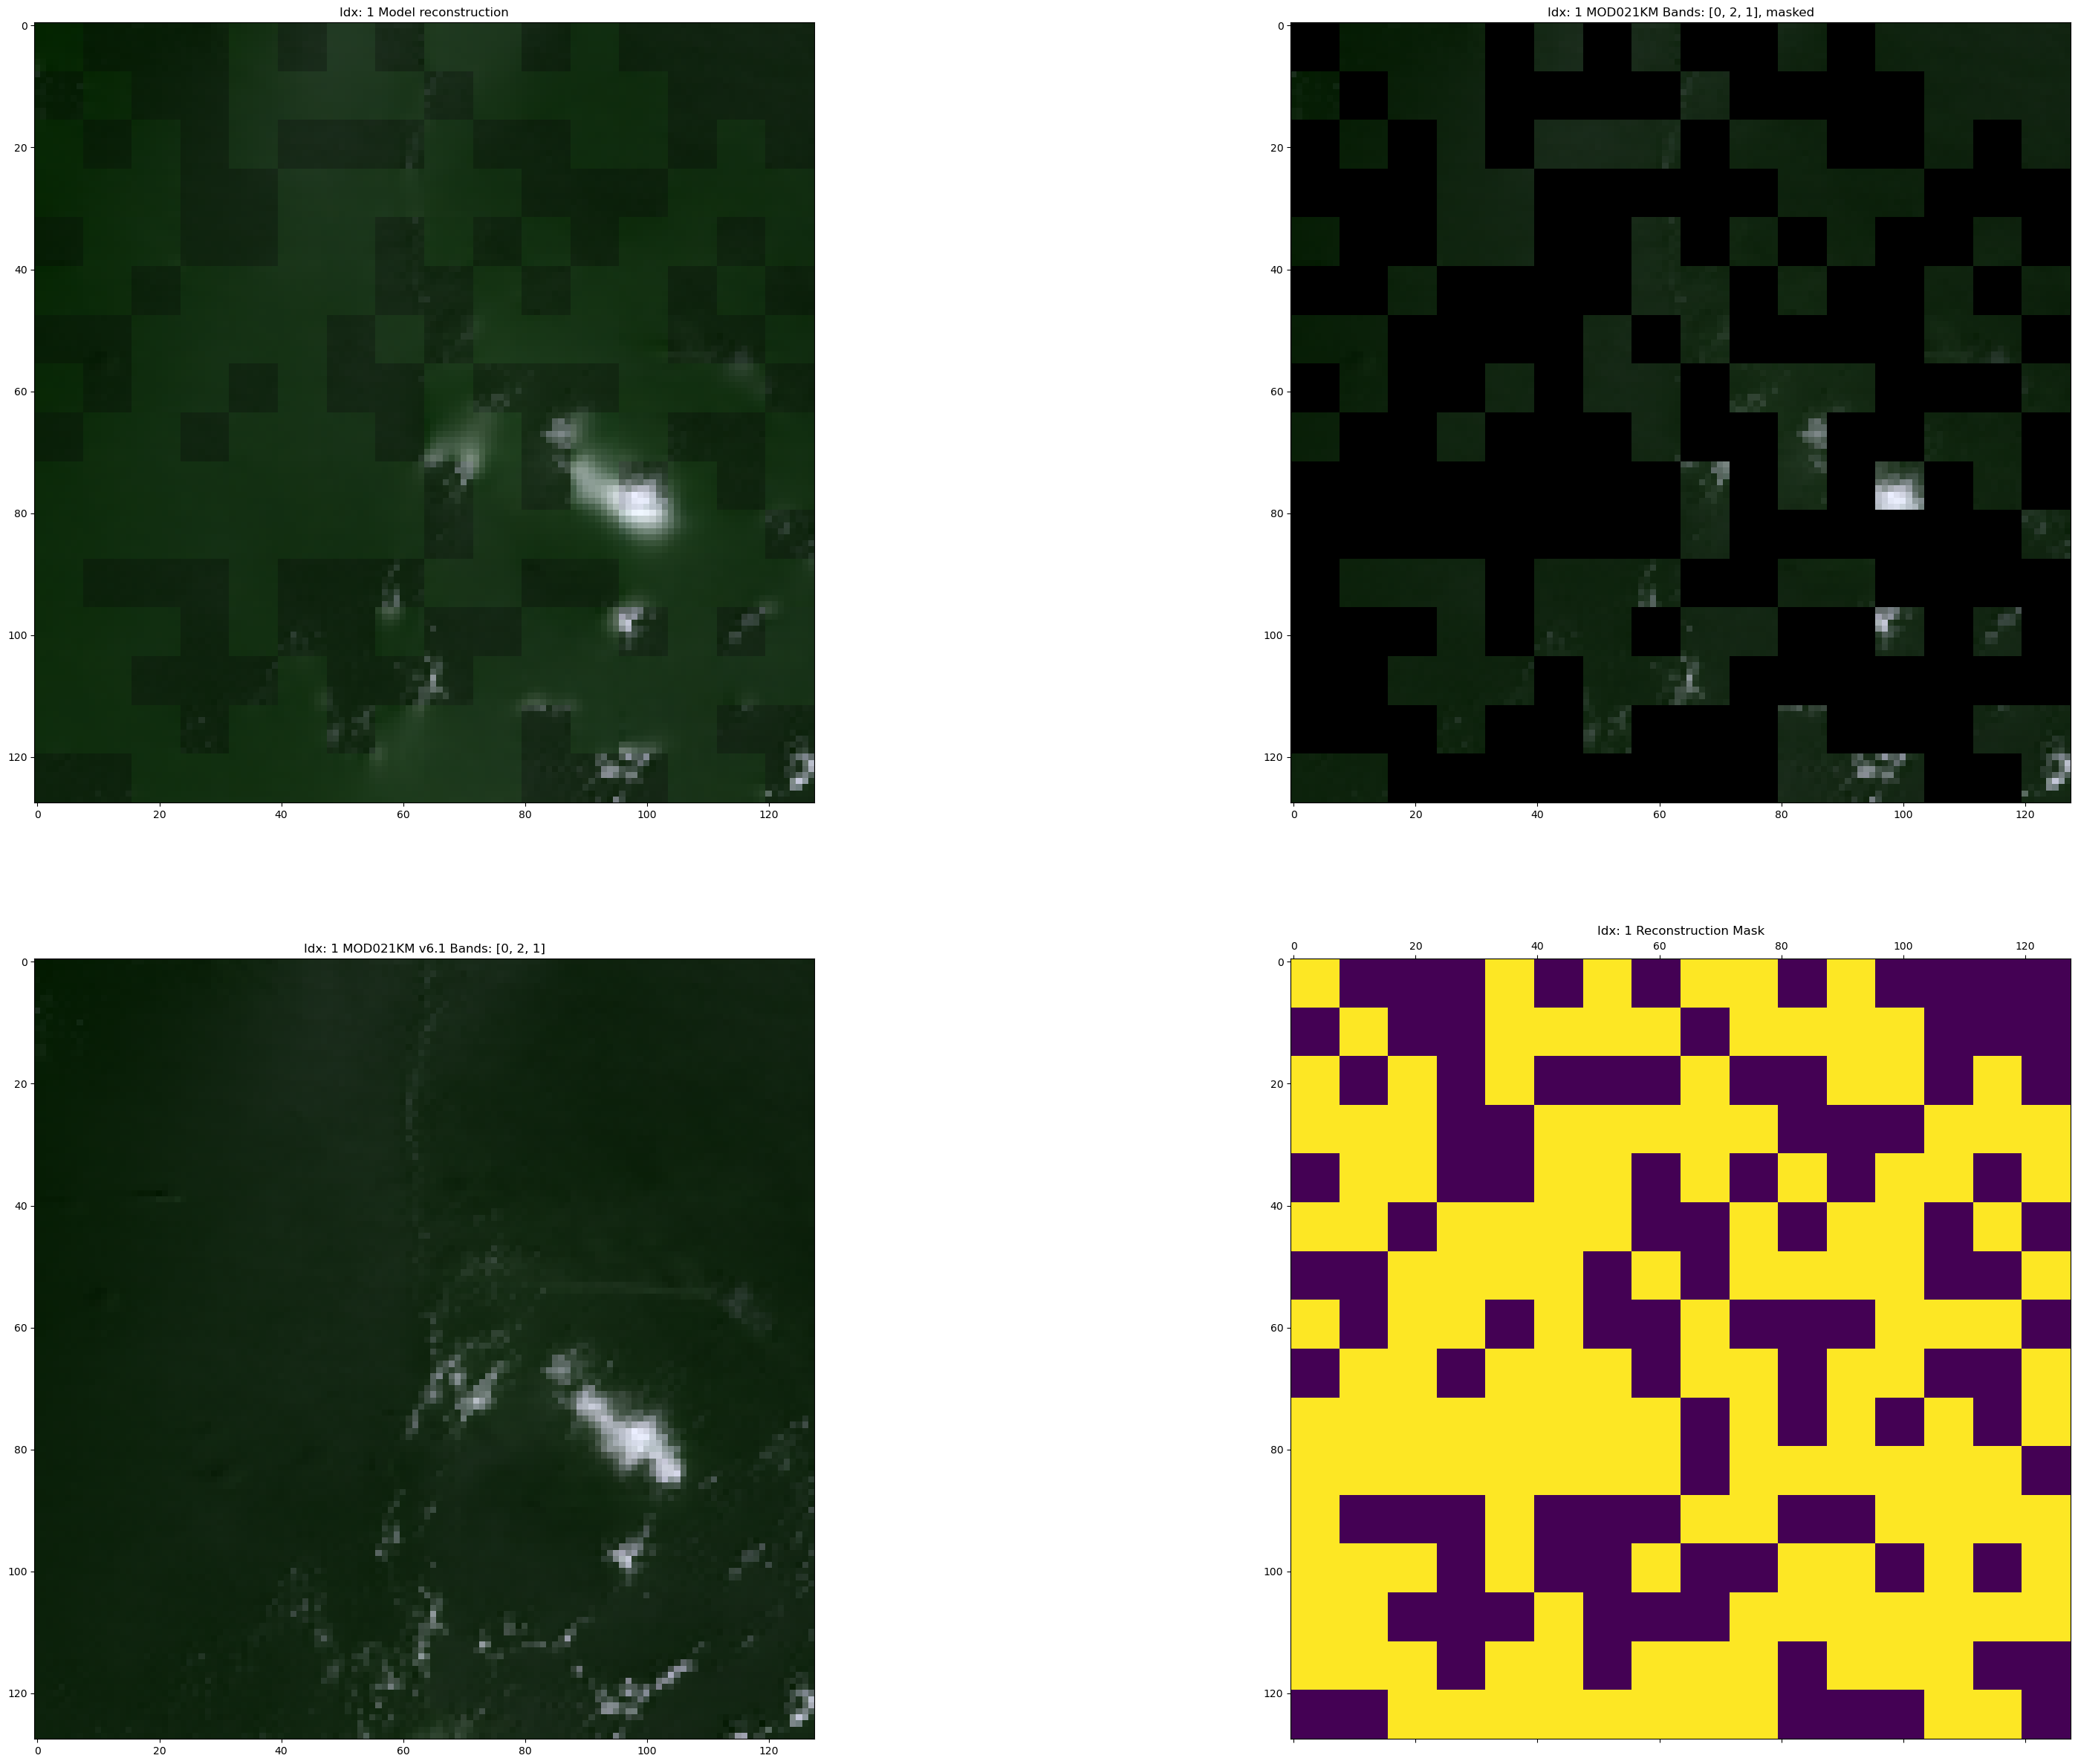

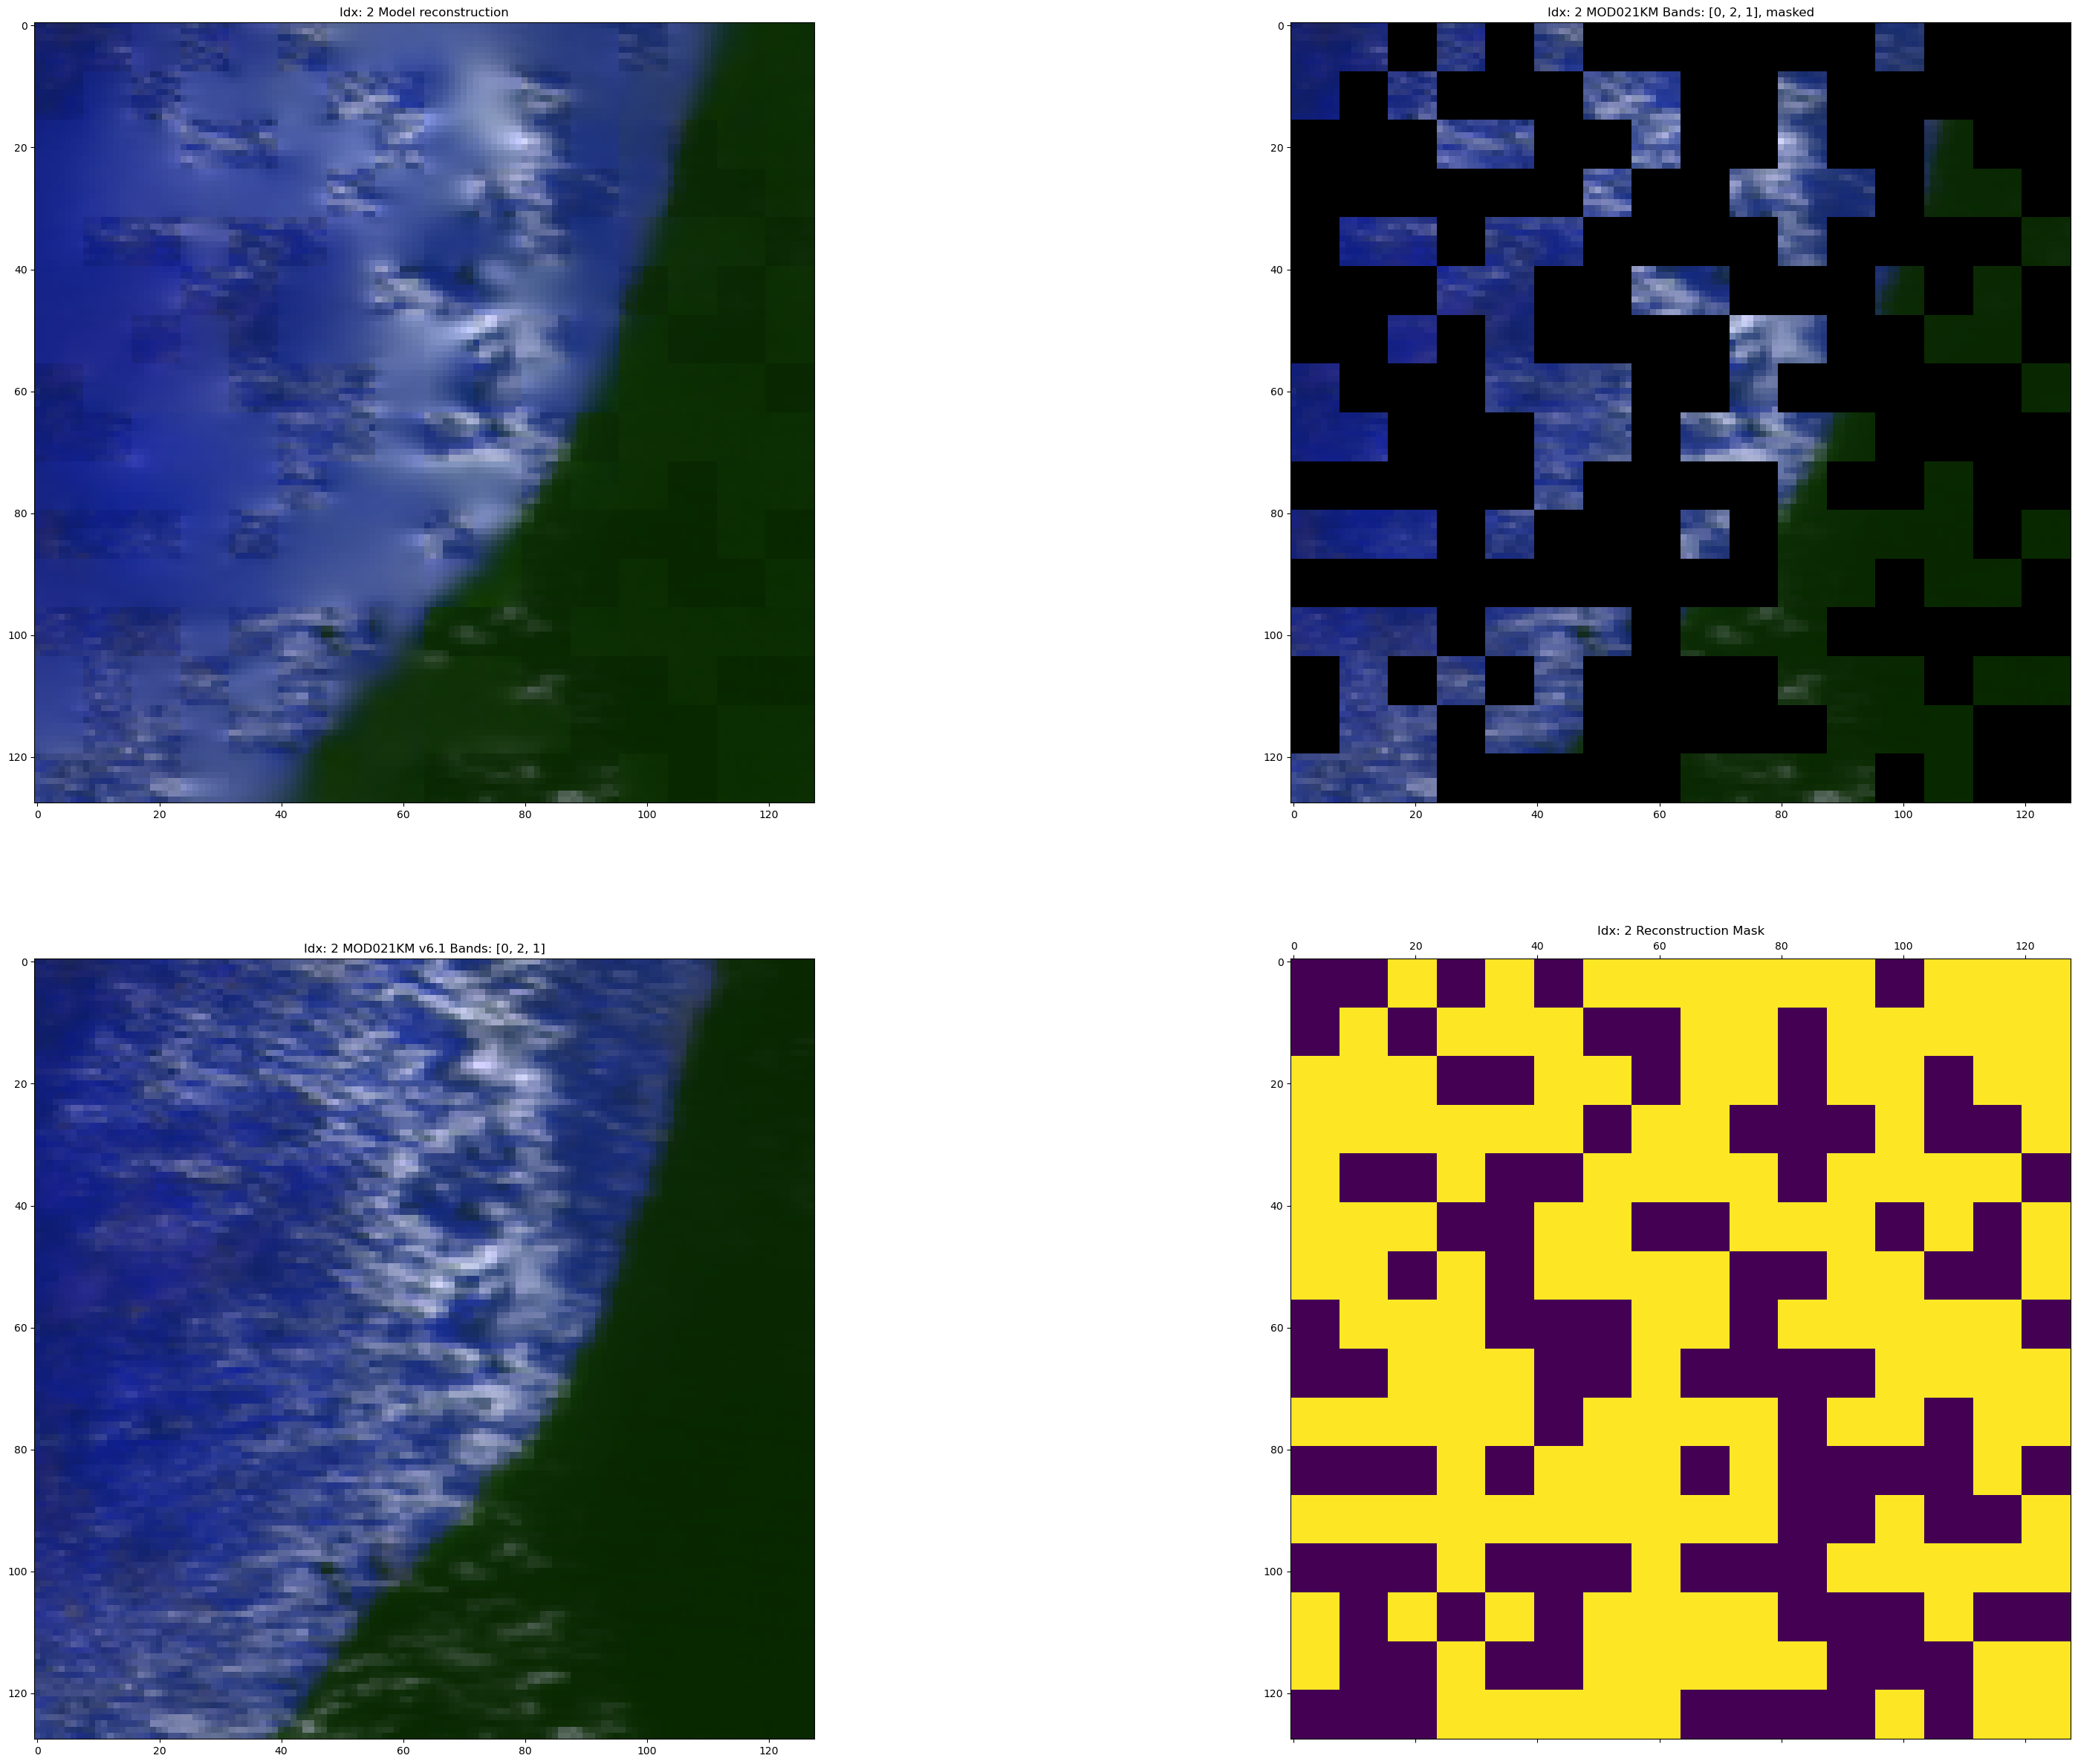

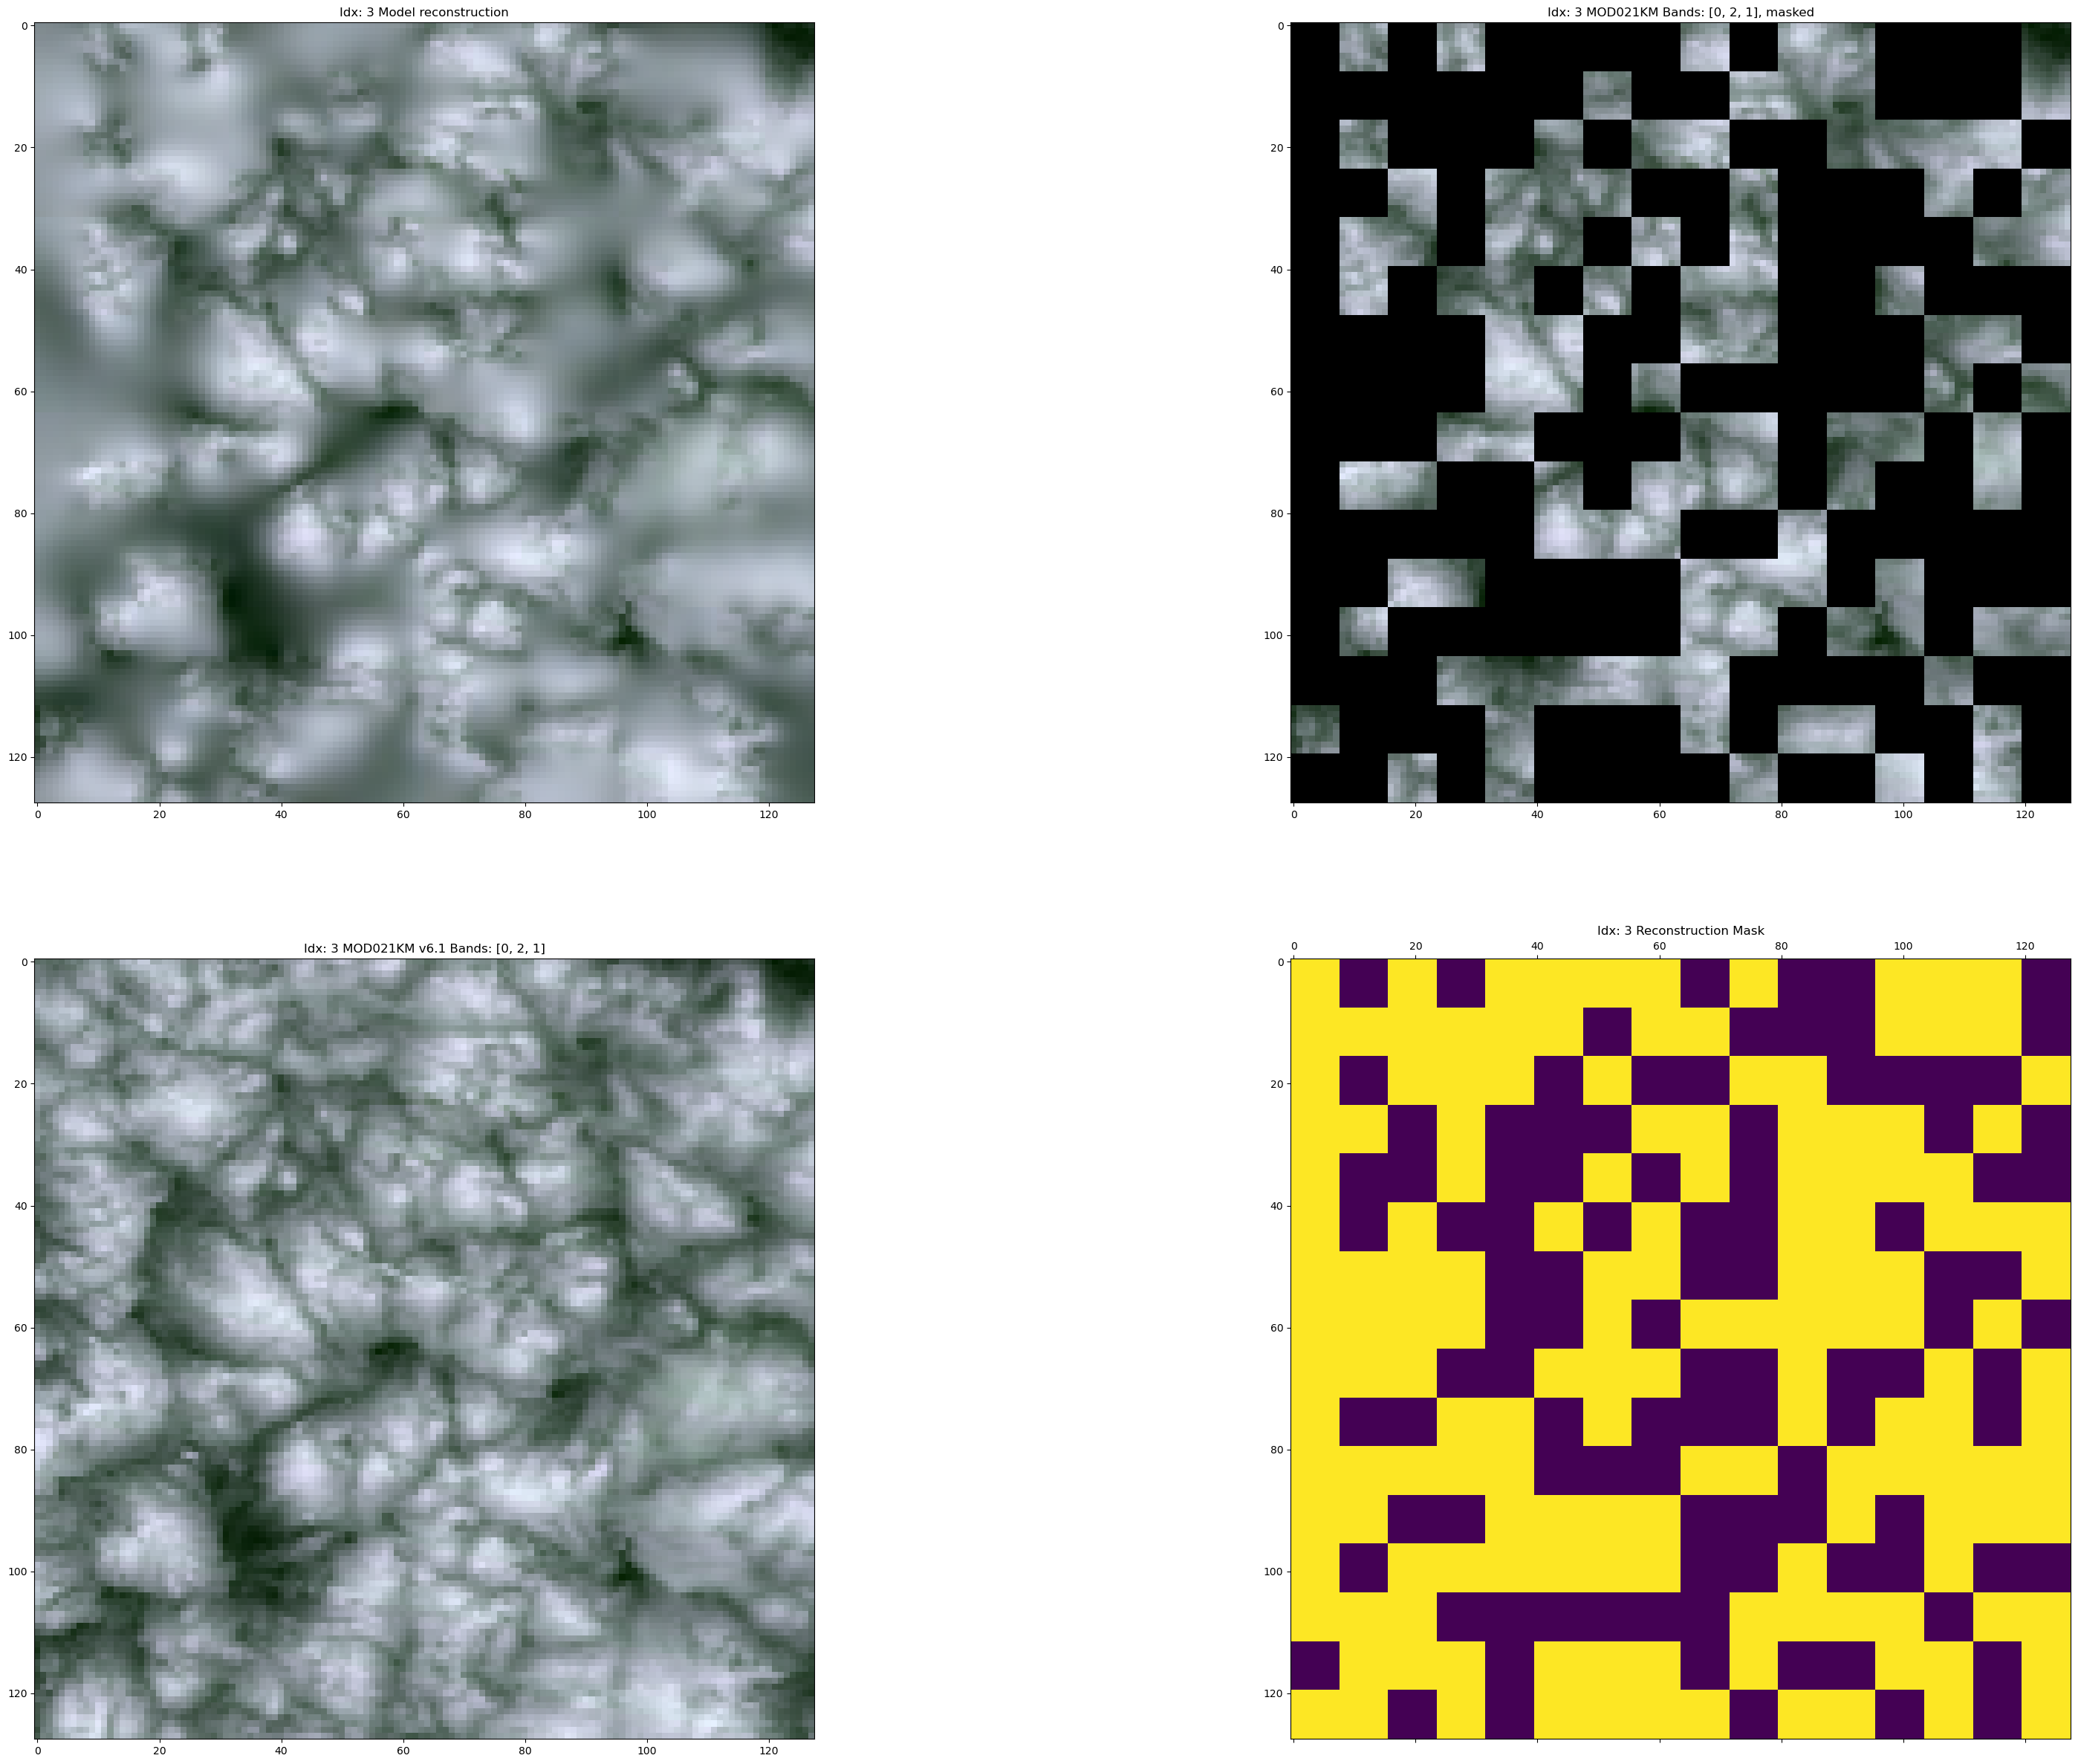

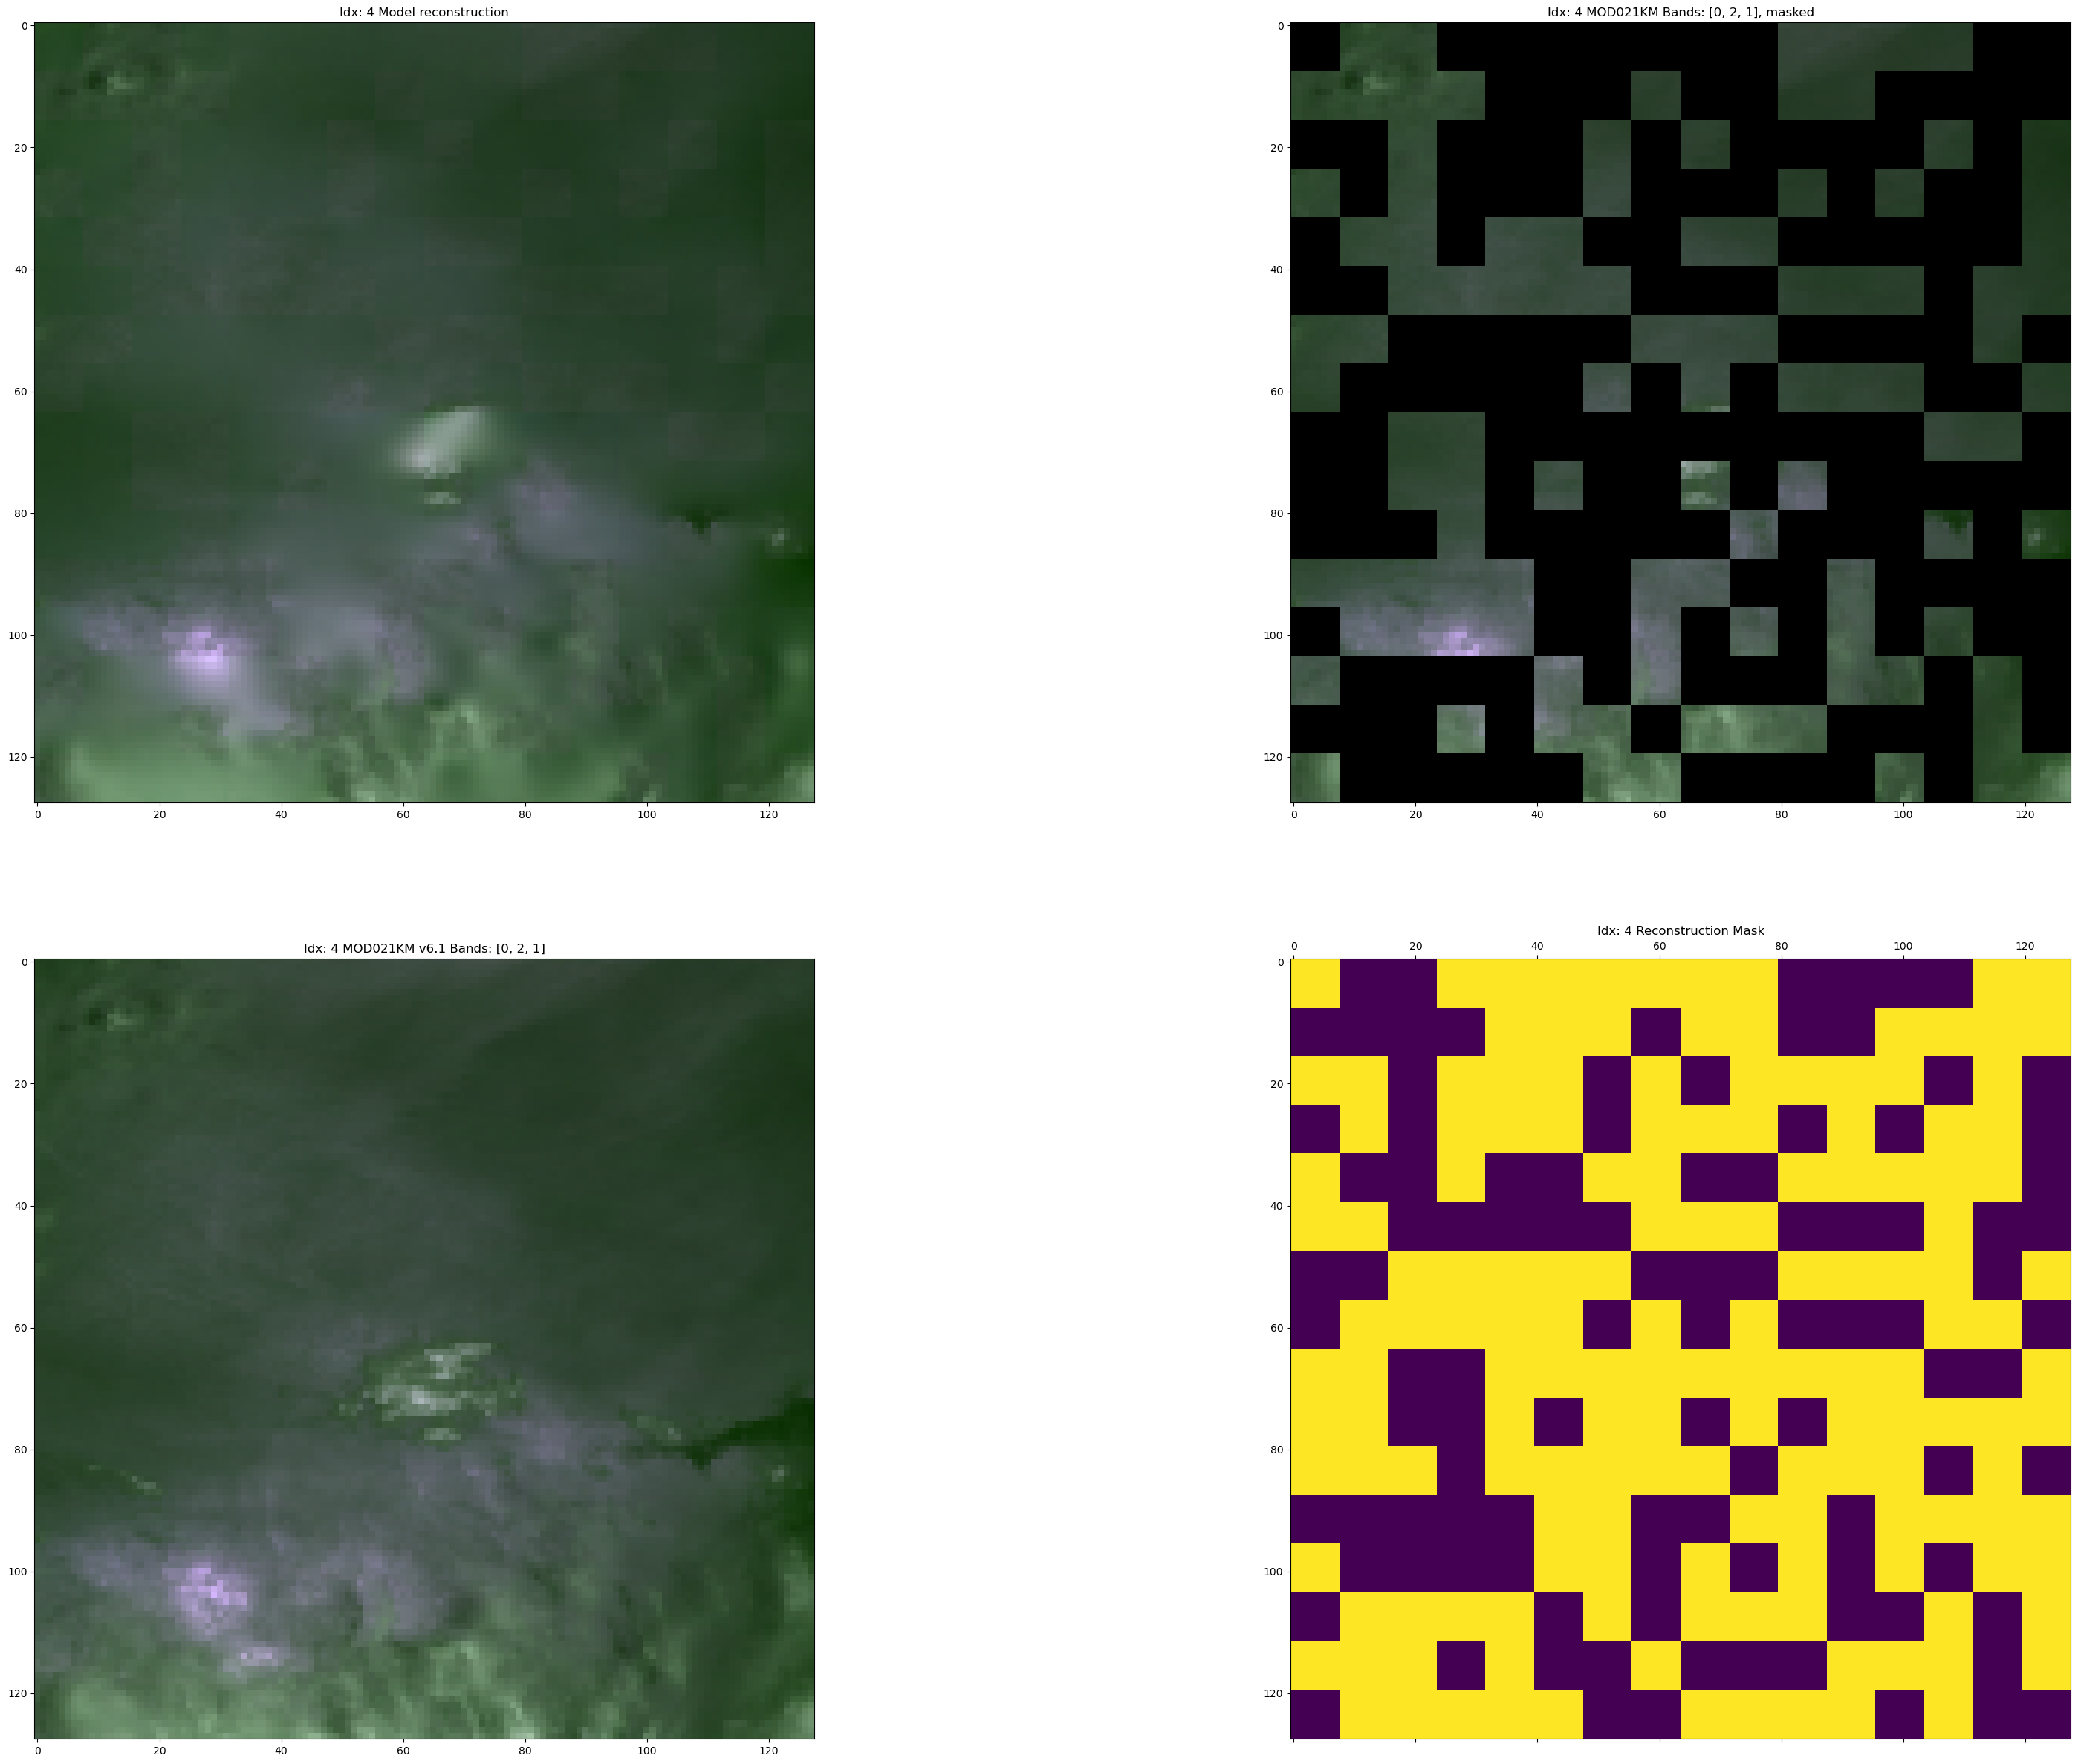

In [15]:
pdf_path = '../../satvision-toa-reconstruction-pdf-giant-patch-8-09.20.pdf'
rgb_index = [0, 2, 1] # Indices of [Red band, Blue band, Green band]

plot_export_pdf(pdf_path, inputs, outputs, masks, rgb_index)